##  How can we use data analytics to predict energy usage for this house?

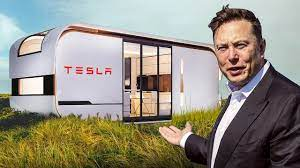


### 1. Read the dataset

In [1]:
#importing various required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import math
import time

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# hide warnings
import warnings
warnings.filterwarnings('ignore')

#reading the csv file into a DataFrame
df = pd.read_csv('energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


### 2. Analyse and visualise the data

In [2]:
#displaying column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [3]:
#checking number of rows with NULL values
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

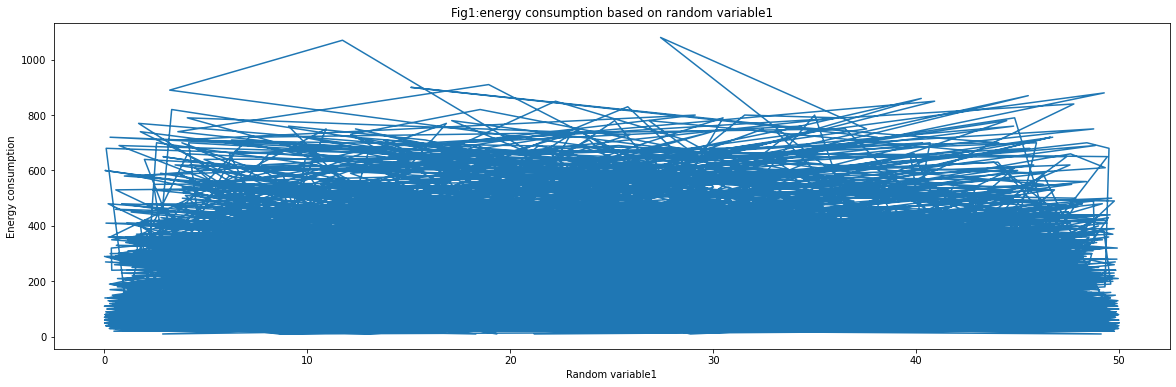

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df['rv1'], df['Appliances'])
ax.set_title("Fig1:energy consumption based on random variable1")
ax.set_xlabel("Random variable1")
ax.set_ylabel("Energy consumption")
plt.show()

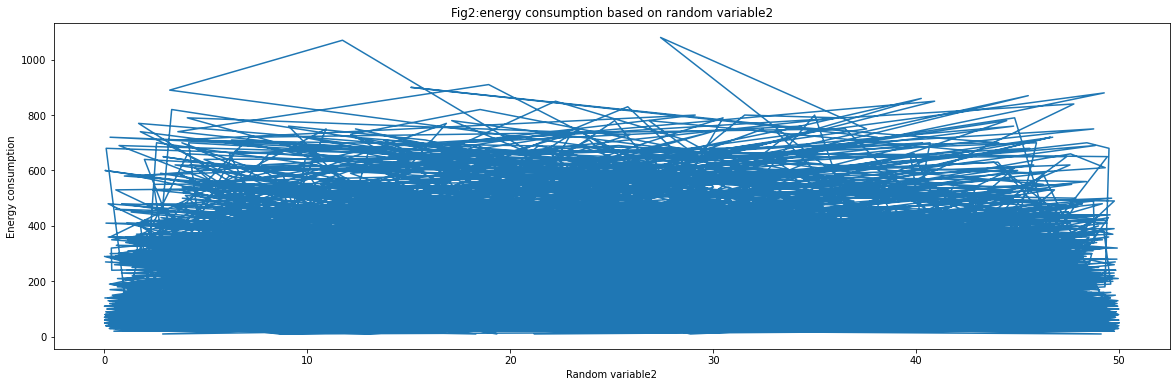

In [5]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df['rv2'], df['Appliances'])
ax.set_title("Fig2:energy consumption based on random variable2")
ax.set_xlabel("Random variable2")
ax.set_ylabel("Energy consumption")
plt.show()

In [6]:
#dropping unnecessary columns
df.drop(columns=['rv1','rv2'],inplace=True)

#creating additional columns
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S') #converting string to date format
df['day_of_week'] = df['date'].dt.day_name() 
df['week_status'] = np.where(df['day_of_week'] == 'Saturday', 'Weekend', np.where(df['day_of_week'] == 'Sunday', 'Weekend', 'Weekday'))
df['week_of_year'] = df['date'].dt.isocalendar().week
df['week_of_year'] = df['week_of_year'].astype(int) #converting string to int format
df['month_of_year'] = ''
count=0
for i in pd.to_datetime(df['date']).dt.month:
    df.at[count,'month_of_year'] = calendar.month_name[i]
    count += 1

#displaying the data
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,day_of_week,week_status,week_of_year,month_of_year
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,6.600000,733.5,92.0,7.000000,63.000000,5.3,Monday,Weekday,2,January
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,6.483333,733.6,92.0,6.666667,59.166667,5.2,Monday,Weekday,2,January
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,6.366667,733.7,92.0,6.333333,55.333333,5.1,Monday,Weekday,2,January
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,6.250000,733.8,92.0,6.000000,51.500000,5.0,Monday,Weekday,2,January
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,6.133333,733.9,92.0,5.666667,47.666667,4.9,Monday,Weekday,2,January


In [7]:
#checking how many categorical and numerical variables are there in the dataFrame
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables:'.format(len(categorical)))
print(categorical)

numerical = [var_1 for var_1 in df.columns if (df[var_1].dtype=='int32') | (df[var_1].dtype=='int64') | (df[var_1].dtype=='float64')]
print('\nThere are {} numerical variables:'.format(len(numerical)))
print(numerical)

There are 3 categorical variables:
['day_of_week', 'week_status', 'month_of_year']

There are 27 numerical variables:
['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'week_of_year']


In [8]:
#printing sub-counts for each categorical variable to understand the data better
for var in categorical: 
    print(df[var].value_counts())

Tuesday      2880
Wednesday    2880
Thursday     2880
Friday       2845
Monday       2778
Saturday     2736
Sunday       2736
Name: day_of_week, dtype: int64
Weekday    14263
Weekend     5472
Name: week_status, dtype: int64
March       4464
April       4320
February    4176
May         3853
January     2922
Name: month_of_year, dtype: int64


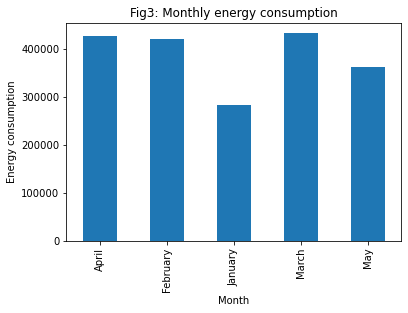

In [9]:
#bar graph to depict the energy consumption monthly
df.groupby('month_of_year')['Appliances'].sum().plot(kind="bar", xlabel="Month", ylabel="Energy consumption",
                                                     title="Fig3: Monthly energy consumption")
plt.show()

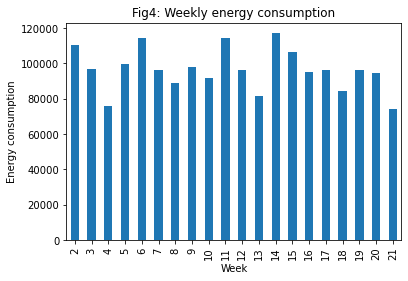

In [10]:
#bar graph to depict the energy consumption weekly
df.groupby('week_of_year')['Appliances'].sum().plot(kind="bar", xlabel="Week", ylabel="Energy consumption",
                                                     title="Fig4: Weekly energy consumption")
plt.show()

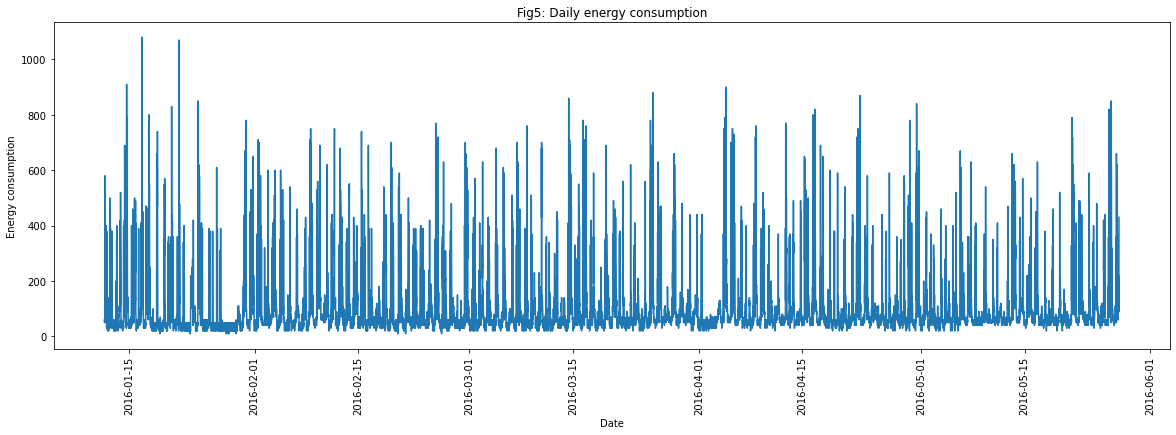

In [11]:
#line graph to depict the energy consumption daily
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df['date'], df['Appliances'])
ax.set_title("Fig5: Daily energy consumption")
ax.set_xlabel("Date")
ax.set_ylabel("Energy consumption")
ax.tick_params('x', rotation=90)
plt.show()

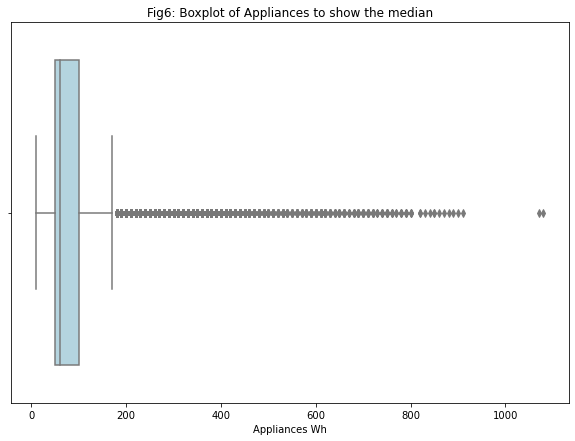

In [12]:
#boxplot to show the median
plt.figure(figsize=(10,7))
sns.boxplot(df['Appliances'], orient='h', color='lightblue')
plt.title("Fig6: Boxplot of Appliances to show the median")
plt.xlabel('Appliances Wh')
plt.show()

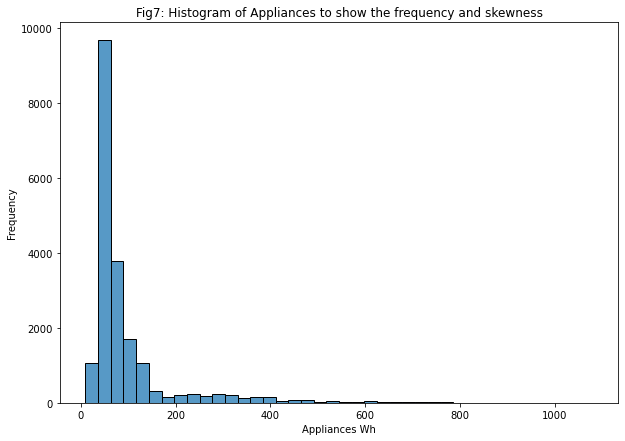

In [13]:
#histogram to show the frequency and the skewness
plt.figure(figsize=(10,7))
sns.histplot(df['Appliances'], bins=40)
plt.title("Fig7: Histogram of Appliances to show the frequency and skewness")
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')
plt.show()

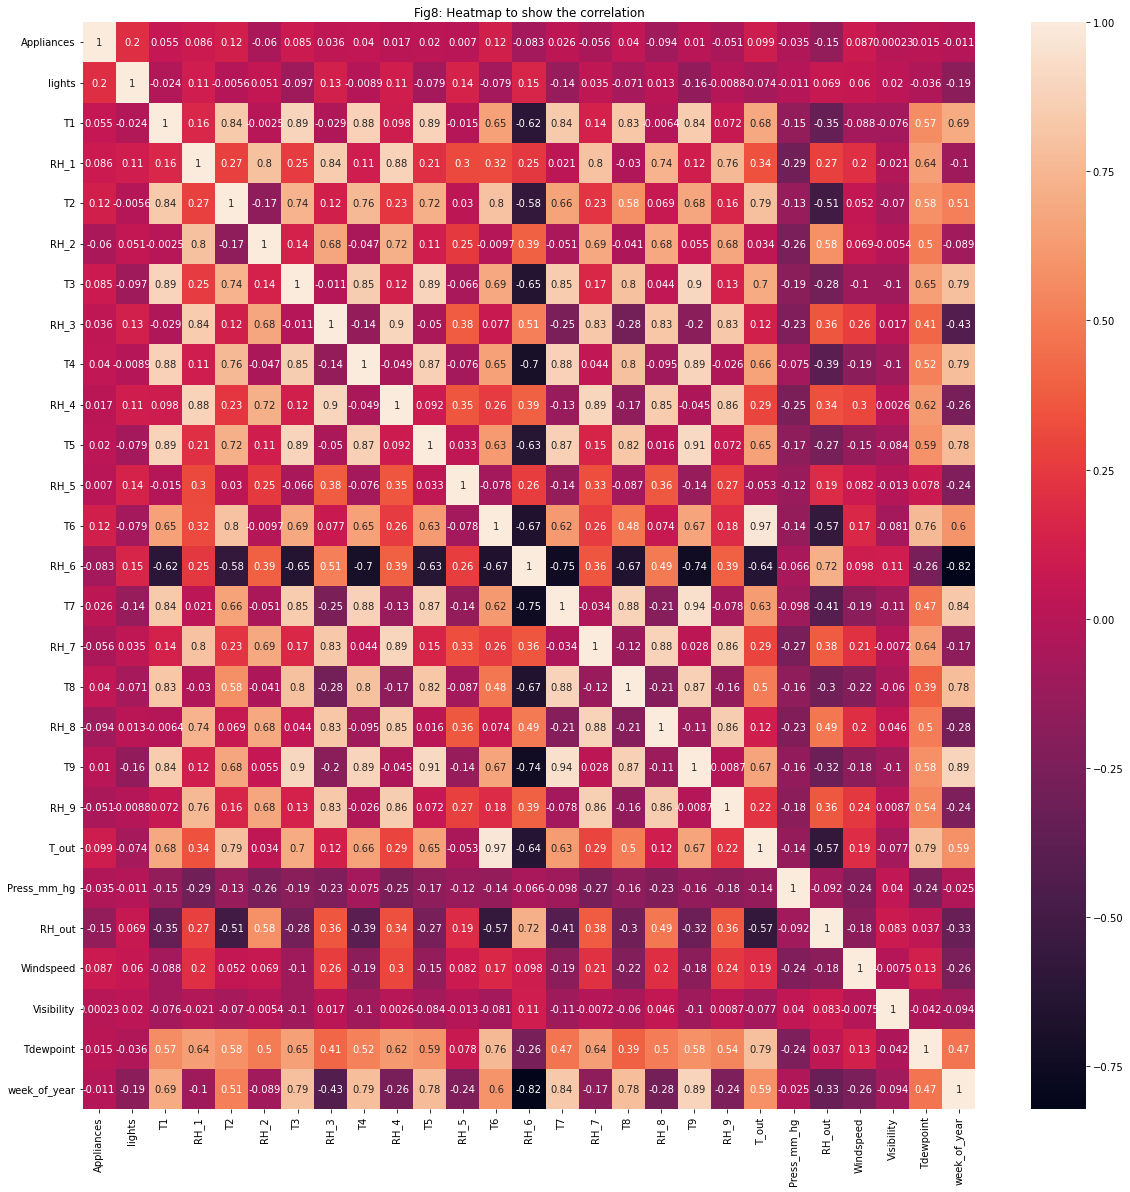

In [14]:
#heatmap to display the correlation of each column
cor = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cor, annot=True)
plt.title("Fig8: Heatmap to show the correlation")
plt.show()

In [15]:
#converting categorical columns to numerical values by creating dummy columns and adding them to original dataFrame
energy_categorical = df.select_dtypes(include=['object'])
energy_categorical.head()
energy_dummies = pd.get_dummies(energy_categorical, drop_first=True)
energy_dummies.head()
df = df.drop(list(energy_categorical.columns), axis=1)
df = pd.concat([df,energy_dummies], axis=1)
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,week_status_Weekend,month_of_year_February,month_of_year_January,month_of_year_March,month_of_year_May
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,0,0,0,0,0,0,0,1,0,0
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,0,0,0,0,0,0,0,1,0,0
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,0,0,0,0,0,0,0,1,0,0
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,0,0,0,0,0,0,0,1,0,0
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,0,0,0,0,0,0,0,1,0,0


##### After analysing and visualising the data:
1. Looking at the columns initially we can see that the columns ‘rv1’ and ‘rv2’ are random variables and have no connection to the target variable ‘Appliances’, hence we can drop these 2 columns.
2. Next, we can see that there are no null/missing values in the dataset, hence we can skip the process of replacing null/missing values with required values.
3. Then, from the ‘date’ column we can extract additional information’s like ‘week_of_year’, ‘month_of_year’ and ‘week_status’ for better understanding the relation of energy consumption on each day.
4. Finally, for training and testing our data, we need to convert the categorical columns into numerical values, for that we need to introduce dummy columns are assign numerical values.
5. From the charts we can see that the data is unimodal and right skewed. It has a median between 50-100, and has a significant amount of outliers.

### 3. Implement prediction models

##### training/testing methodology:
1. We are splitting the original data into 80% training data and 20% testing data, since it is important to strike a balance between having enough data for training the model and having enough data for evaluating the model's performance. The random state set to 40, so that the split is same everytime it is run.
2. Also we will be applying a 5-fold cross validation, since it helps to provide a more reliable estimate of the model's performance by reducing the impact of randomness in the train-test split.

In [16]:
#Splitting the data to train and test
df_train,df_test=train_test_split(df,train_size=0.8, random_state=40)

#converting Appliances value to log
y_train = np.log(df_train.Appliances)
#removing Appliances column in the trained data
X_train = df_train.drop("Appliances",1)

#converting Appliances value to log
y_test= np.log(df_test.Appliances)
#removing Appliances column in the test data
X_test = df_test.drop("Appliances",1)

#selecting variables that are numerical to transform them
num_vars=X_train.select_dtypes(include=['int32','int64','float64','uint8']).columns
print("Numberical variables: ",num_vars)

#transforming the data
scaler = StandardScaler()
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])
X_test = X_test._get_numeric_data()
y_test = y_test._get_numeric_data()
X_train = X_train._get_numeric_data()
y_train = y_train._get_numeric_data()

Numberical variables:  Index(['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5',
       'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint',
       'week_of_year', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'week_status_Weekend',
       'month_of_year_February', 'month_of_year_January',
       'month_of_year_March', 'month_of_year_May'],
      dtype='object')


In [17]:
#showing how the source trained data looks
X_train.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,week_status_Weekend,month_of_year_February,month_of_year_January,month_of_year_March,month_of_year_May
14323,-0.481179,-0.297913,-0.568112,-0.973062,0.211780,0.064966,-0.414609,0.264491,-0.880709,0.206204,...,-0.399504,-0.402696,-0.413153,-0.419541,2.429064,-0.619238,-0.519664,-0.416090,-0.540841,-0.491215
8578,-0.481179,-0.864457,-1.020163,-1.657024,0.334442,-0.846832,-0.568080,-0.519655,-1.135789,-0.973465,...,-0.399504,-0.402696,-0.413153,-0.419541,-0.411681,-0.619238,-0.519664,-0.416090,1.848972,-0.491215
2277,-0.481179,-1.194421,1.441000,-0.641720,1.266681,-1.185214,1.826068,-1.102864,1.876913,-1.130874,...,-0.399504,-0.402696,-0.413153,-0.419541,2.429064,-0.619238,-0.519664,2.403324,-0.540841,-0.491215
7255,-0.481179,-0.609201,-0.043232,-0.562684,0.285377,-0.830163,-0.202819,-0.808809,0.059181,-0.336589,...,-0.399504,-0.402696,-0.413153,-0.419541,2.429064,-0.619238,-0.519664,-0.416090,1.848972,-0.491215
12593,-0.481179,-0.260559,-0.199775,-0.836269,0.761309,0.064966,-0.261138,-0.122681,-0.122363,0.166399,...,-0.399504,-0.402696,-0.413153,-0.419541,-0.411681,-0.619238,-0.519664,-0.416090,-0.540841,-0.491215


In [18]:
#showing how the target trained data looks
y_train.head()

14323    3.688879
8578     3.401197
2277     3.401197
7255     3.912023
12593    3.912023
Name: Appliances, dtype: float64

### 4. Train prediction models

##### Model selction
We will be predicting the models using Regression models, we cannot use a classification model since our target variable is continuous numerical. Under the regression models, we will be using Linear regression and a specialized form of linear regression model, called Lasso regression model, where the model is penalized for the sum of absolute values of the weights. Thus, the absolute values of weight will be (in general) reduced, and many will tend to be zeros. We are using these 2 models since they are very flexible to be used with wide range of input variables and are relatively faster in processing large datasets. Moreover, model coefficients provide insights into the relationship between the input variables and the output variable, allowing you to interpret the results and gain insights into the underlying mechanisms of the process being modelled.

In [19]:
#linear regression
lm=LinearRegression()
start = time.time()
lm.fit(X_train,y_train)
end = time.time()

#Recursive feature elimination 
rfe = RFE(lm,n_features_to_select=15)
rfe=rfe.fit(X_train,y_train)

col=X_train.columns[rfe.support_]
print(col)

X_train_new=X_train[col]

X_train_new = sm.add_constant(X_train_new)

#prediciting the data using the trained and split data
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

#storing the model used, r2, mae, mse, rmse values to a list for printing later
results=[]
model_data={}
model_data['Model']='Linear regression'
model_data['Trained_r2_score']=metrics.r2_score(y_true=y_train, y_pred=y_train_pred)
model_data['Tested_r2_score']=metrics.r2_score(y_true=y_test, y_pred=y_test_pred)
model_data['mae']=mean_absolute_error(y_test, y_test_pred)
model_data['mse']=mean_squared_error(y_test, y_test_pred)
model_data['rmse']=math.sqrt(mean_squared_error(y_test, y_test_pred))
model_data['Time_taken']=end-start
results.append(model_data)

Index(['lights', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T6', 'T7', 'T8', 'RH_8',
       'T9', 'T_out', 'RH_out', 'Tdewpoint', 'month_of_year_January'],
      dtype='object')


In [20]:
#lasso
params = {'alpha': [0.00005, 0.0001, 0.001, 0.008, 0.01]}
lasso = Lasso()

# cross validation
model_cv_l = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_l.fit(X_train, y_train)

# cv results
cv_results_l = pd.DataFrame(model_cv_l.cv_results_)
print(cv_results_l)

#checking the value of optimum number of parameters
print("Best param is: ", model_cv_l.best_params_)
print("Best score is: ", model_cv_l.best_score_)

alpha = 0.001 #place value that gives the best param value

lasso = Lasso(alpha=alpha)

#fitting the model
start = time.time()
lasso.fit(X_train, y_train)
end = time.time()

#prediciting the data using the trained and split data
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

#storing the model used, r2, mae, mse, rmse values to a list for printing later
model_data={}
model_data['Model']='Lasso regression'
model_data['Trained_r2_score']=metrics.r2_score(y_true=y_train, y_pred=y_train_pred)
model_data['Tested_r2_score']=metrics.r2_score(y_true=y_test, y_pred=y_test_pred)
model_data['mae']=mean_absolute_error(y_test, y_test_pred)
model_data['mse']=mean_squared_error(y_test, y_test_pred)
model_data['rmse']=math.sqrt(mean_squared_error(y_test, y_test_pred))
model_data['Time_taken']=end-start
results.append(model_data)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.406677      0.031245         0.006249        0.007653     0.00005   
1       0.449002      0.081778         0.003123        0.006246      0.0001   
2       0.156216      0.017113         0.003121        0.006241       0.001   
3       0.043736      0.006256         0.003124        0.006247       0.008   
4       0.045558      0.010623         0.000415        0.000830        0.01   

              params  split0_test_score  split1_test_score  split2_test_score  \
0   {'alpha': 5e-05}          -0.398665          -0.386883          -0.384686   
1  {'alpha': 0.0001}          -0.398606          -0.386784          -0.384637   
2   {'alpha': 0.001}          -0.398365          -0.386252          -0.384359   
3   {'alpha': 0.008}          -0.403162          -0.392331          -0.389346   
4    {'alpha': 0.01}          -0.405113          -0.394232  

### 5. Test predictin models and show results

Trained model R-squared value is:  0.2899555132098115
Tested model R-squared value is:  0.2744892323411309
RMSE is:  0.5575248500726598
MAE is:  0.3910700223591488


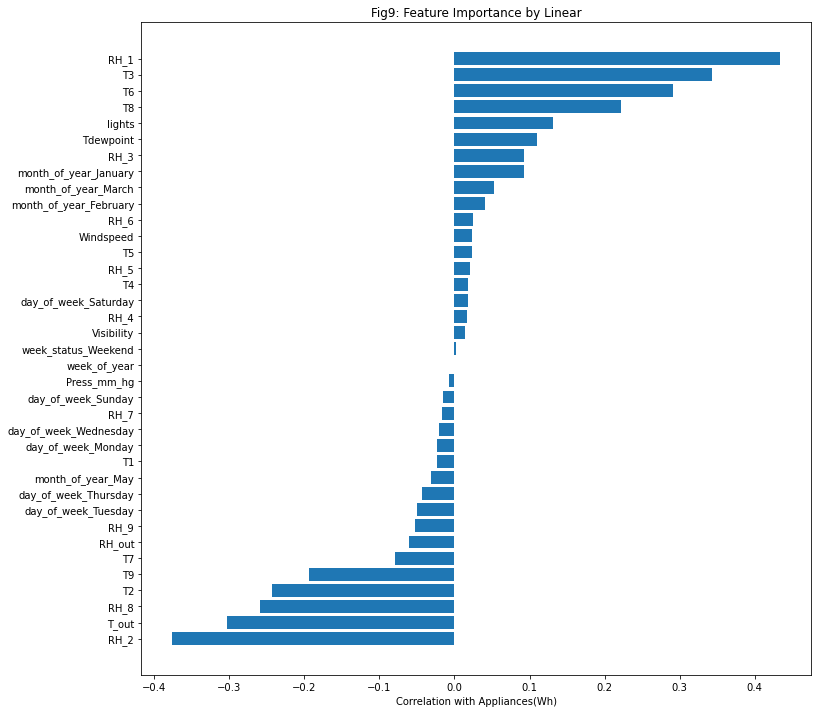

In [21]:
#linear
y_train_pred = lm.predict(X_train)
print("Trained model R-squared value is: ", metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

y_test_pred = lm.predict(X_test)
print("Tested model R-squared value is: ", metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

from sklearn.metrics import mean_squared_error, mean_absolute_error
print ('RMSE is: ', math.sqrt(mean_squared_error(y_test, y_test_pred)))
print ('MAE is: ', mean_absolute_error(y_test, y_test_pred))

#Feature importance plot
feature_importance = lm.coef_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Fig9: Feature Importance by Linear')
plt.xlabel("Correlation with Appliances(Wh)")
plt.show()

Trained model R-squared value is:  0.2885693398459719
Tested model R-squared value is:  0.2732132619730697
RMSE is:  0.5580148997815939
MAE is:  0.39047065576412116


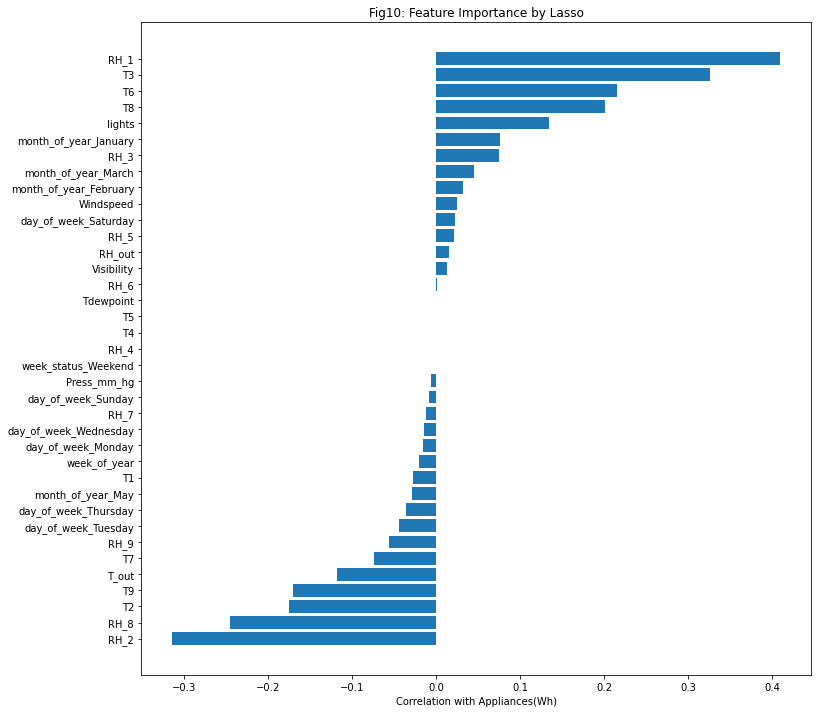

In [22]:
#lasso
y_train_pred = lasso.predict(X_train)
print("Trained model R-squared value is: ", metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

y_test_pred = lasso.predict(X_test)
print("Tested model R-squared value is: ", metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

from sklearn.metrics import mean_squared_error
print ('RMSE is: ', math.sqrt(mean_squared_error(y_test, y_test_pred)))
print ('MAE is: ', mean_absolute_error(y_test, y_test_pred))

#Feature importance plot
feature_importance = lasso.coef_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Fig10: Feature Importance by Lasso')
plt.xlabel("Correlation with Appliances(Wh)")
plt.show()

### 6. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results

In [23]:
results_df = pd.DataFrame(results)
results_df

,Model,Trained_r2_score,Tested_r2_score,mae,mse,rmse,Time_taken
0,Linear regression,0.289956,0.274489,0.391070,0.310834,0.557525,0.024720
1,Lasso regression,0.288569,0.273213,0.390471,0.311381,0.558015,0.187463


1. In linear regression, the trained_r2_score=0.290, whereas in lasso, the trained_r2_score=0.288, which is just 0.002 difference. The tested_r2_score=0.274 in linear and the 0.273 in lasso, giving a difference of 0.001. The mean absolute error(MAE)=0.391 in linear and 0.390 in lasso, thereby having a difference of 0.001. The mean squared error(MSE)=0.310 in linear and 0.311 in lasso, giving a difference of 0.001. The root mean squared error(RMSE)=0.557 in linear  and 0.558 in lasso, giving a difference of 0.001. Finally the time taken to fit linear regression model=0.02s and 0.19s by lasso, giving a difference of 0.17s.
2. From the above results, we can see that both the models, logistic and lasso regressions do not have much of a difference in their R-squared, MAE, MSE and RMSE values. The only significant difference we can see is in the time taken to fit the model. Hence Linear Regression is a better model, when compared to lasso regression. 
3. If we wanted to understand better which model is best, ROC curve and confusion matrix would help, but we cannot create ROC curve or confusion matrix, since it is typically used to evaluate the performance of classification models, which predict categorical labels, and we are predicting a continuous numerical variable.

### 7. Reflect on what you have learned by completing this assignment

1. I have learnt how to define a problem, identify the relevant variables, and collect or generate data to support your analysis.
2. I have also learnt how to preprocess the data by cleaning and scaling, and how to analyze the data using various statistical and visualization techniques to gain insights and identify patterns.
3. Learnt how to select and train prediction models using including linear regression and Lasso regression. Also gained knowledge on how to use cross-validation to evaluate and tune the models, and how to interpret the results using performance metrics such as mean squared error, mean absolute error, and R-squared.
4. Learnt how to use Python and various libraries such as sklearn and matplotlib to implement and evaluate the models.

### 8. References